# Deep Neural Netork For Image Classification

My goal was to create a model that can classify many different terrains, I was unable to complete that so I just made a binary classification model. Im still learning and hopefully I can implement a model that can classify many different objects in the next coming week. 

This model work well for binary classification with train/test sets with low costs, and good predictions around 95%, HOWEVER the one important thing I didnt do was to shift the datasets, meaning that the images are in order for example y = [0, 0, 0 , 0 , 0, 1, 1 , 1, 1, 1], the model might've picked this up and it could be why its doing so well!

The accuracy went down to 50% when I increased the amount of images, not sure why but I believe its cause right now its only seeing the images of buildings and forests. Some of the buildings images have trees next to them. The images are picked at random. So I reran it and the model got a higher accuracy 100% train and 83% test.

The dataset is from https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from utils.dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
import copy
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import sklearn.datasets
import sklearn.linear_model


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

/Users/tonyavis/miniconda3/envs/AI_env/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Load data

the x_train images will be of shape (# of images, # pixel count x, num pixel count y, 3)
the dataset is images of different places  buildings, forests, mountains, glaciers, seas, street

the y/labels will be of shape (1, # of images)

In [2]:
from PIL import Image #pillow module
from utils.imageNNUtils import load_many_images_for_binary_classification, load_image, image_to_pixels

In [3]:
imgPath = "./datasets/images_of_places_NN/seg_train/buildings/4.jpg"

In [4]:
loadedImg = load_image(imgPath)

In [5]:
pixelData = image_to_pixels(loadedImg)

In [6]:
pixelData.shape

(150, 150, 3)

In [7]:
classes = [ "forest", "buildings", "glacier", "street", "mountain", "sea"  ]

In [8]:
numImagesToLoad = 30

In [9]:
# some image sizes arent all the same keep trying til it randomly selects all images of the same size
train_x_orig, train_y = load_many_images_for_binary_classification(numImagesToLoad, "./datasets/images_of_places_NN/seg_train")
test_x_orig, test_y = load_many_images_for_binary_classification( round(numImagesToLoad/5), "./datasets/images_of_places_NN/seg_train")

folders names ['forest', 'buildings']
folders names ['forest', 'buildings']


y = 0. It's a forest picture.


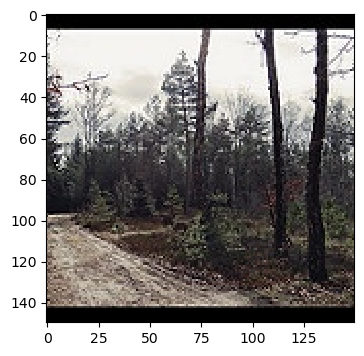

In [10]:
index = 9
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]] +  " picture.")
plt.imshow(train_x_orig[index])

In [11]:
train_x_orig.shape

(60, 150, 150, 3)

In [12]:
train_y.shape

(1, 60)

In [13]:
test_x_orig.shape

(12, 150, 150, 3)

In [14]:
test_y.shape

(1, 12)

In [15]:
test_y
# TODO this needs to be randomized along with the x data

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])

# Reshape and normalize the image data

The image train data goes from shape of (# of images, pixelCountX, pixelCountY, 3) to
(pixelCountX * pixelCountY * 3 , # of images) this allows us to matrix multiply them with the weights
and bairs
<pre>
train_x = 
    
[ (one image here as column), (another image here as column)..........number of images ]
[ (image pixel one)         ,    (image pixel one) ,        ..........(image pixel one)]
[ (image pixel two)         ,    (image pixel two) ,         .........(image pixel two)]
[ (image pixel three)       ,    (image pixel three),       .... (image pixel three)   ]
[  ........,          , .........                   , ..........                       ]
[ (last image pixel)       ,    (last image pixel),       .... (last image pixel)      ]
</pre>

In [16]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (67500, 60)
test_x's shape: (67500, 12)


# Build Out The Model

In [17]:
from utils.dnn_utils import *

In [18]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [19]:
layers_dims = [train_x.shape[0], 20, 7, 5, 1] 
# layers_dims = [train_x.shape[0], 20, 7, 5, len(classes)]
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)
# parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 300, print_cost = True)

Cost after iteration 0: 0.6871667559130963
Cost after iteration 100: 0.33513939495532663
Cost after iteration 200: 0.06262495151727641
Cost after iteration 300: 0.03507782218525212
Cost after iteration 400: 0.02263465069518801
Cost after iteration 500: 0.01744182901209612
Cost after iteration 600: 0.015362208086989322
Cost after iteration 700: 0.014243122074071518
Cost after iteration 800: 0.013473400002514815
Cost after iteration 900: 0.012959408130174583
Cost after iteration 1000: 0.012560566972638692
Cost after iteration 1100: 0.012266229366407663
Cost after iteration 1200: 0.012024116791066096
Cost after iteration 1300: 0.0118199469255352
Cost after iteration 1400: 0.011650519108747044
Cost after iteration 1500: 0.011498820019005726
Cost after iteration 1600: 0.011379284345329855
Cost after iteration 1700: 0.011261181965414176
Cost after iteration 1800: 0.011144382650522432
Cost after iteration 1900: 0.011050929817627559
Cost after iteration 2000: 0.010955856175059639
Cost after it

# Predict

In [20]:
# train set the same data it was trained on
pred_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [21]:
# on new data
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8333333333333335
